In [1]:
using Revise

In [2]:
using Distributed
procs_to_use = 1

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@everywhere @consts begin
    λ = 626e-9
    Γ = 2π* 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **



In [3]:
@everywhere sim_params = @params_mnt begin
    
    # B-field parameters during blue MOT
    B_gradient = 50
    B_offset = (0e-3, 0e-3, 300e-3)
    B_ramp_time = 30e-3
    
    # Laser parameters
    s1 = 2.18
    s2 = 1.82  
    s_ramp_time = 30e-3
    s_ramp_to = 0.7
    pol_imbalance = 0.01
    s_imbalance = (0.0, 0.05, -0.05)
    retro_loss = 0.02
    off_center = (2, -2, -2, 2, 2, 2) .* 1e-3
    pointing_error = (0,0,0,0,0,0)
    pol1_x = [1,0,0]
    pol2_x = [0,0,1]
    voltage = -1.4
    aom_freq = 53.55
    
    # ODT parameters
    # ODT_intensity = 0*13.3*1e3/(50e-4)^2
    ODT_intensity = 30*1e3/(50e-4)^2
    ODT_size = (30e-6, 2e-3, 30e-6)
    ODT_position = [0., 0.]
    ODT_revs = 4
    ODT_motion_t_start = 0.0
    ODT_motion_t_stop = 120e-3
    ODT_pol = [0,1,0]
    ODT_rmax = 160e-6
    
end
;

In [4]:
# @everywhere begin
#     # SF cooling parameters
#     sim_params.B_gradient = 0
#     sim_params.s1 = 20.0
#     sim_params.s2 = 0.0
#     sim_params.voltage = 20.0
#     sim_params.s_ramp_to = 1.0
    
#     # # make polarization linear
#     # pol1_x = [0,1,0]
#     # pol2_x = [0,1,0]
# end

# @everywhere begin
#     # Lambda cooling parameters
#     sim_params.B_gradient = 0
#     sim_params.s1 = 8.0
#     sim_params.s2 = 4.0
#     sim_params.voltage = 0.0
#     sim_params.s_ramp_to = 1.0
#     sim_params.aom_freq = 52.75 #- 1.0
# end

@everywhere begin
    # SF cooling parameters, testing
    sim_params.B_gradient = 0
    sim_params.s1 = 40.0
    sim_params.s2 = 0.0
    sim_params.voltage = 40.0
    sim_params.s_ramp_to = 1.0
    
    # # make polarization linear
    # pol1_x = [0,1,0]
    # pol2_x = [0,1,0]
end
;

### Define CaOH states

In [5]:
@everywhere begin
    include("define_CaOH_states.jl")
    X_states, A_states, ham_matrix = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)
end
;

### Define lasers

In [6]:
@everywhere begin
    include("define_lasers.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.voltage,
        sim_params.aom_freq
    )
end
;

### Define Hamiltonian for the ODT-molecule interaction

In [7]:
@everywhere begin
    include("define_ODT_Hamiltonian.jl")
    H_ODT = get_H_ODT(states, X_states, A_states, sim_params.ODT_intensity, sim_params.ODT_pol)
end
;

### Define Zeeman Hamiltonian

In [8]:
@everywhere include("define_Zeeman_Hamiltonian.jl")
;

### Run simulation

In [9]:
@everywhere function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
#     Zeeman_Hz = p.extra_data.Zeeman_Hz
#     Zeeman_Hx = p.extra_data.Zeeman_Hx
#     Zeeman_Hy = p.extra_data.Zeeman_Hy
    
#     τ_bfield = p.sim_params.B_ramp_time / (1/Γ)
#     scalar = t/τ_bfield
#     scalar = min(scalar, 1.0)
    
#     gradient_x = -scalar * p.sim_params.B_gradient * 1e2 / k / 2
#     gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
#     gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
#     Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
#     By = gradient_y * r[2] + p.sim_params.B_offset[2]
#     Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
#     @turbo for i in eachindex(H)
#         H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
#         H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
#     end
    
    # Update the Hamiltonian for the molecule-ODT interaction
    H_ODT = p.extra_data.H_ODT
    H_ODT_static = p.extra_data.H_ODT_static
    @turbo for i in eachindex(H_ODT)
       H_ODT.re[i] = H_ODT_static.re[i]
       H_ODT.im[i] = H_ODT_static.im[i]
    end
    
    # Update the ODT position
    update_ODT_center_spiral!(p.sim_params, p.extra_data, t)
#     # update_ODT_center_circle!(p.sim_params, p.extra_data, t)
    
    ODT_x = p.sim_params.ODT_position[1] / (1 / p.k)
    ODT_z = p.sim_params.ODT_position[2] / (1 / p.k)
    # ODT_x = 0.0
    ODT_y = 0e-3 / (1 / p.k)
    # ODT_z = 0.0
    
    ODT_size = p.sim_params.ODT_size .* p.k
    
    scalar_ODT = exp(-2(r[1]-ODT_x)^2/ODT_size[1]^2) * exp(-2(r[2]-ODT_y)^2/ODT_size[2]^2) * exp(-2(r[3]-ODT_z)^2/ODT_size[3]^2)
    
    @turbo for i in eachindex(H)
        H.re[i] = H_ODT.re[i] #* scalar_ODT
        H.im[i] = H_ODT.im[i] #* scalar_ODT
    end
    
    ∇H = SVector{3, Float64}((-4(r[1]-ODT_x) / ODT_size[1]^2) * scalar_ODT, (-(4r[2]-ODT_y) / ODT_size[2]^2) * scalar_ODT, (-4(r[3]-ODT_z) / ODT_size[3]^2) * scalar_ODT)
    
    return ∇H
end
;

In [10]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat,
    H_ODT_static = StructArray(H_ODT),
    H_ODT = deepcopy(StructArray(H_ODT)),
    ODT_as = ODT_as,
    ODT_τs = ODT_τs
)
;

In [11]:
@everywhere function sample_velocity(T)
    return sqrt(kB * T / m) .* (rand(Normal(0,1)), rand(Normal(0,1)), rand(Normal(0,1)))
end
;

In [12]:
# Design 1: one long vector with all ds
# Design 2: three vectors, one for each of d_1, d_2, d_3 (q = -1, 0, +1)

# H: a vector with the same length as nonzero elements in d
# dE: a vector with the values d_iq*E_q

In [13]:
using StaticArrays, LoopVectorization, BenchmarkTools, StructArrays

In [35]:
@inline function update_E_and_E_k!(E, E_k, Es, ks, sat_params) # multiplication of the two matrices Es and ks might be faster
    # this can definitely be faster
    @inbounds @fastmath for i ∈ 1:3
        E_k[i] = (zero(eltype(E_k[i])), zero(eltype(E_k[i])), zero(eltype(E_k[i])))
        E[i] = 0.0
    end
    @inbounds @fastmath for i ∈ axes(Es, 1)
        E_i = (sqrt(sat_params[i]) / (2√2)) * Es[i,:] # can make the prefactor constants
        k_i = ks[i,:]
        for k ∈ 1:3
            E_k[k] += E_i * k_i[k]
        end
        E .+= E_i
    end
    return nothing
end
@btime update_E_and_E_k!($(p_fast.E_soa), $(p_fast.E_k), $(p_fast.Es), $(p_fast.ks), $(p_fast.sat_params))

  33.032 ns (0 allocations: 0 bytes)


In [61]:
@inline function update_E_k!(E_k, Es, ks, sat_params) # multiplication of the two matrices Es and ks might be faster
    # this can probably be faster
    @inbounds @fastmath for i ∈ 1:3
        E_k[i] = (zero(eltype(E_k[i])), zero(eltype(E_k[i])), zero(eltype(E_k[i])))
    end
    @inbounds @fastmath for i ∈ axes(Es, 1)
        E_i = (sqrt(sat_params[i]) / (2√2)) * Es[i,:] # can make the prefactor constants
        k_i = ks[i,:]
        for k ∈ 1:3
            E_k[k] += E_i * k_i[k]
        end
    end
    return nothing
end
@btime update_E_k!($(p_fast.E_k), $(p_fast.Es), $(p_fast.ks), $(p_fast.sat_params))

  25.402 ns (0 allocations: 0 bytes)


In [1439]:
@inline function update_E!(E, E_k)
    @inbounds @fastmath for i ∈ 1:3
        E_i = zero(eltype(E))
        for k ∈ 1:3
            E_i += E_k[k][i]
        end
        E[i] = E_i
    end
    return nothing
end
@btime update_E!($(p_fast.E_soa), $(p_fast.E_k))

  3.500 ns (0 allocations: 0 bytes)


In [32]:
@inline function update_fields_fast1!(krs, ks, r, ωs, t, exp_vals)
    @inbounds @fastmath for i ∈ eachindex(krs)
        krs_i = zero(eltype(krs))
        for j ∈ 1:3
            krs_i += ks[i,j] * r[j]
        end
        krs[i] = krs_i
        exp_vals[i] = -krs_i + ωs[i] * t
    end
    return nothing
end

@inline function update_fields_fast2!(res, ims, exp_vals)
    @turbo for i ∈ eachindex(exp_vals)
        ims[i], res[i] = sincos(exp_vals[i])
    end
    return nothing
end

@inline function update_fields_fast3!(Es, ϵs, res, ims)
    @inbounds @fastmath for i ∈ axes(Es,1)
        prefactor = res[i] + im * ims[i]
        for j ∈ 1:3
            Es[i,j] = prefactor * conj(ϵs[i,j])
        end
    end
    return nothing
end

@inline function update_fields_fast_composed!(krs, ks, r, ωs, t, exp_vals, Es, ϵs, ims, res)
    
    update_fields_fast1!(krs, ks, r, ωs, t, exp_vals)
    update_fields_fast2!(res, ims, exp_vals)
    update_fields_fast3!(Es, ϵs, res, ims)
    
    return nothing
end

@btime update_fields_fast1!($(p_fast.krs), $(p_fast.ks), $(p_fast.r), $(p_fast.ωs), $t, $(p_fast.exp_vals))
@btime update_fields_fast_composed!($(p_fast.krs), $(p_fast.ks), $(p_fast.r), $(p_fast.ωs), $t, $(p_fast.exp_vals), $(p_fast.Es), $(p_fast.ϵs), $(p_fast.ims), $(p_fast.res))

# is this actually slower than previous function? seems comparable, or very slightly faster

  4.600 ns (0 allocations: 0 bytes)
  47.677 ns (0 allocations: 0 bytes)


In [1298]:
@btime update_fields!($(p.fields), $(p.r), $t)

  51.773 ns (0 allocations: 0 bytes)


In [13]:
function make_couplings(H)
    ds_state1 = Int64[]
    ds_state2 = Int64[]
    ds = Float64[]
    for i ∈ axes(H, 1)
        for j ∈ i:size(H, 2)
            if norm(H[i,j]) > 1e-10
                push!(ds_state1, j)
                push!(ds_state2, i)
                push!(ds, H[i,j])
            end
        end
    end
    return (ds_state1, ds_state2, ds)
end
;

In [14]:
(ds_state1_ODT, ds_state2_ODT, ds_ODT) = make_couplings(H_ODT)

([1, 8, 2, 5, 3, 6, 10, 4, 7, 11  …  11, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1, 1, 2, 2, 3, 3, 3, 4, 4, 4  …  7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [-5.9232175851376905, -1.6755564790061492, -5.830000718997164, -1.762941686509483, -5.96786826114236, 0.8092551042186203, 1.4143894305487243, -5.96786826114236, 0.8092551042186203, -1.4143894305487243  …  -1.3723173709099385, -2.6062339822982312, -5.685832881291085, -3.3761337070464448, -3.3761337070464448, -5.685832881291085, 5.9234622984275145, 5.923462277431913, 5.923462258224494, 5.923462258224494])

In [537]:
type_to_use = Float64

n_excited = 4

ψ = rand(Complex{type_to_use}, 16)
dψ = rand(Complex{type_to_use}, 16)

ψ_mutable = MVector{16, Complex{type_to_use}}(ψ)
dψ_mutable = MVector{16, Complex{type_to_use}}(dψ)

u = rand(Complex{type_to_use}, length(ψ)+n_excited+6)
du = deepcopy(u)
u[17:end] .= 0.0

n_fields = 6

t = 0.0 # 132.2

# Static arrays

r = zeros(type_to_use, 3)
r_static = SVector{3, type_to_use}(r)
ks = rand(type_to_use, n_fields, 3)

for i ∈ 1:n_fields
    ks[i,:] .= p.fields.k[i]
end

ks_static = SMatrix{n_fields,3}(ks)
ωs = zeros(type_to_use, n_fields)

for i ∈ 1:n_fields
    ωs[i] = p.fields.ω[i]
end
ωs_static = SVector{n_fields, type_to_use}(ωs)

# Mutable arrays

krs = zeros(type_to_use, n_fields)
krs_mutable = MVector{n_fields, type_to_use}(krs)

ims = rand(type_to_use, n_fields)
res = rand(type_to_use, n_fields)
ims_mutable = MVector{n_fields, type_to_use}(ims)
res_mutable = MVector{n_fields, type_to_use}(res)

exp_vals = rand(type_to_use, n_fields)
exp_vals_mutable = MVector{n_fields, type_to_use}(exp_vals)
exp_vals_static = SVector{n_fields, type_to_use}(exp_vals)

Es = rand(Complex{type_to_use}, n_fields, 3)
ϵs = rand(Complex{type_to_use}, n_fields, 3)

for i ∈ 1:n_fields
    ϵs[i,:] .= p.fields.ϵ_val[i]
end

Es_mutable = MMatrix{n_fields,3}(Es)
ϵs_static = SMatrix{n_fields,3}(ϵs)

sat_params = p.fields.s
sat_params_static = SVector{n_fields, type_to_use}(p.fields.s)

# 

ds1 = SVector{10, type_to_use}(p.ds[1])
ds2 = SVector{10, type_to_use}(p.ds[2])
ds3 = SVector{10, type_to_use}(p.ds[3])

ds = [ds1; ds2; ds3]
dEs = MVector{30, Complex{type_to_use}}(zeros(Complex{type_to_use}, length(ds)))
dEs_soa=StructArray(dEs)
E = SVector(0.3, 0.2, 0.3+0.5im)

ds_added=SVector{length(ds_ODT), Complex{type_to_use}}(ds_ODT)
ds_state1_added=SVector{length(ds_state1_ODT), Int64}(ds_state1_ODT)
ds_state2_added=SVector{length(ds_state2_ODT), Int64}(ds_state2_ODT)
dEs_soa_added=StructArray(ds_added)

H = deepcopy(dEs)

# ds_state1 = (SVector{10, Int64}(p.ds_state1[1]), SVector{10, Int64}(p.ds_state1[2]), SVector{10, Int64}(p.ds_state1[3]))
# ds_state2 = (SVector{10, Int64}(p.ds_state2[2]), SVector{10, Int64}(p.ds_state2[2]), SVector{10, Int64}(p.ds_state2[3]))

ds_state1 = [p.ds_state1[1]; p.ds_state1[2]; p.ds_state1[3]]
ds_state2 = [p.ds_state2[1]; p.ds_state2[2]; p.ds_state2[3]]

ds_state1 = SVector{30, Int64}([p.ds_state1[1]; p.ds_state1[2]; p.ds_state1[3]])
ds_state2 = SVector{30, Int64}([p.ds_state2[1]; p.ds_state2[2]; p.ds_state2[3]]) 

ωs_states = p.ω
ωs_states_static = SVector{16, type_to_use}(ωs_states)

#
ψ_repeats = rand(Complex{type_to_use}, 30)
ψ_repeats = MVector{30, Complex{type_to_use}}(ψ_repeats)
ψ_repeats_soa = StructArray(ψ_repeats)

dψ_repeats = rand(Complex{type_to_use}, 30)
dψ_repeats = MVector{30, Complex{type_to_use}}(dψ_repeats)
dψ_repeats_soa = StructArray(dψ_repeats)

ψ_soa = StructArray(ψ_mutable)

f = MVector{3, Complex{type_to_use}}(zeros(Complex{type_to_use}, 3))

p_fast = MutableNamedTuple(
    
    r=r_static,
    
    krs=krs_mutable,
    ks=ks_static,
    ωs=ωs_static, 
    exp_vals=exp_vals_mutable,
    Es=Es_mutable,
    ϵs=ϵs_static,
    ims=ims_mutable,
    res=res_mutable,
    
    # total electric fields
    E_soa=StructArray(E),
    E_k=[SVector{3, Complex{type_to_use}}(zeros(Complex{type_to_use}, 3)) for _ ∈ 1:3], # should this be a tuple?
    E_k_soa=StructArray(MMatrix{3, 3, Complex{type_to_use}}(zeros(Complex{type_to_use}, 3, 3))),
    sat_params=sat_params_static,
    
    # dipole matrix couplings
    ds=ds,
    ds1=ds1,
    ds2=ds2,
    ds3=ds3,
    ds_state1=ds_state1,
    ds_state2=ds_state2,
    ψ_repeats1_soa=deepcopy(ψ_repeats_soa),
    ψ_repeats2_soa=deepcopy(ψ_repeats_soa),
    dψ_repeats1_soa=deepcopy(dψ_repeats_soa),
    dψ_repeats2_soa=deepcopy(dψ_repeats_soa),
    # d_exp=SVector{3, Complex{type_to_use}}(zeros(Complex{type_to_use}, 3)),
    d_exp=MVector{3, Complex{type_to_use}}(zeros(Complex{type_to_use}, 3)),
    # d_exp=MVector{3, type_to_use}(zeros(type_to_use, 3)),
    
    # extra terms
    ds_added=ds_added,
    ds_state1_added=ds_state1_added,
    ds_state2_added=ds_state2_added,
    E_ODT=p.sim_params.ODT_intensity,
    
    # Hamiltonian terms
    dEs_soa=dEs_soa,
    dEs_soa_added=dEs_soa_added,
    
    # states information
    ωs_states=ωs_states_static,
    eiωt=StructArray(MVector{16, Complex{type_to_use}}(zeros(Complex{type_to_use}, 16))),
    
    #
    ψ_soa=ψ_soa,
    dψ_soa=deepcopy(ψ_soa),
    n_states=length(ψ_soa),
    n_excited=n_excited,
    
    sim_params=sim_params,
    extra_data=extra_data,
    
    k=k,
    Γ=Γ,
    
    f=f
)
;

In [16]:
using BenchmarkTools

In [17]:
@inline function update_eiωt!(eiωt, ωs, t)
    @turbo for i ∈ eachindex(ωs)
        eiωt.im[i], eiωt.re[i] = sincos(ωs[i] * t)
    end
    return nothing
end
@btime update_eiωt!($(p_fast.eiωt), $ωs_states_static, $t)

  41.473 ns (0 allocations: 0 bytes)


In [18]:
@inline function u_to_ψ!(u, ψ, n_states) # can u be made soa? this would help slightly here, but not sure if compatible with the differential equation solver...
    @inbounds @fastmath for i ∈ 1:n_states
        ψ.re[i] = real(u[i])
        ψ.im[i] = imag(u[i])
    end
    return nothing
end
@btime u_to_ψ!($u, $(p_fast.ψ_soa), $(p_fast.n_states))

  11.311 ns (0 allocations: 0 bytes)


In [19]:
@inline function ψ_to_u!(ψ, u, n_states) # can u be made soa? this would help slightly here, but not sure if compatible with the differential equation solver...
    @inbounds @fastmath for i ∈ 1:n_states
        u[i] = ψ.re[i] + im * ψ.im[i]
    end
    return nothing
end
@btime ψ_to_u!($(p_fast.dψ_soa), $u, $(p_fast.n_states))

  8.809 ns (0 allocations: 0 bytes)


In [20]:
function normalize_ψ!(ψ)
    ψ_norm = zero(Float64)
    @turbo for i ∈ eachindex(ψ)
        ψ_norm += ψ.re[i]^2 + ψ.im[i]^2
    end
    ψ_norm = sqrt(ψ_norm)
    @turbo for i ∈ eachindex(ψ)
        ψ.re[i] /= ψ_norm
        ψ.im[i] /= ψ_norm
    end                           
    return nothing
end
@btime normalize_ψ!($(p_fast.ψ_soa))

  18.800 ns (0 allocations: 0 bytes)


In [21]:
const mass = m/(ħ*k^2/Γ)

358.2585502351211

In [22]:
f = SVector(p_fast.E_k[1] ⋅ p_fast.E_soa, p_fast.E_k[2] ⋅ p_fast.E_soa, p_fast.E_k[3] ⋅ p_fast.E_soa)
function update_position_and_force!(du, u, f, n_states, n_excited)
    @inbounds @fastmath for i ∈ 1:3
        du[n_states + n_excited + i] = u[n_states + n_excited + i + 3] # update d(position)/dt
        du[n_states + n_excited + 3 + i] = f[i] / mass # update d(velocity)/dt
    end
    return nothing
end
@btime update_position_and_force!($du, $u, $f, $(p_fast.n_states), $(p_fast.n_excited))

  2.800 ns (0 allocations: 0 bytes)


In [23]:
@inline function ψ_ordering_soa!(ψ_soa, ψ_repeats_soa, ds_state)
    # there must be a better way to do this resorting...
    # maybe associate each state with a list of transitions, so that each easier to sum over them?
    # this will probably work for this function but not the reverse mapping
    @turbo for i ∈ eachindex(ψ_soa)
        ψ_soa.re[i] = zero(Float64)
        ψ_soa.im[i] = zero(Float64)
    end
    @inbounds for i ∈ eachindex(ψ_repeats_soa)
        idx = ds_state[i]
        ψ_soa.re[idx] += ψ_repeats_soa.re[i]
        ψ_soa.im[idx] += ψ_repeats_soa.im[i]
    end
    return nothing
end
@btime ψ_ordering_soa!($(p_fast.ψ_soa), $(p_fast.ψ_repeats1_soa), $(p_fast.ds_state1))

  25.878 ns (0 allocations: 0 bytes)


In [617]:
@inline function ψ_ordering_soa_reverse!(ψ_soa, ψ_repeats1_soa, ψ_repeats2_soa, ds_state1, ds_state2) 
    # there must be a better way to do this resorting...
    # maybe associate each state with a list of transitions, so that each easier to sum over them?
    # this will probably work for this function but not the reverse mapping
    @turbo for i ∈ eachindex(ψ_soa)
        ψ_soa.re[i] = zero(Float64)
        ψ_soa.im[i] = zero(Float64)
    end
    @inbounds @fastmath for i ∈ eachindex(ψ_repeats1_soa)
        idx1 = ds_state1[i]
        ψ_soa.re[idx1] += ψ_repeats1_soa.re[i]
        ψ_soa.im[idx1] += ψ_repeats1_soa.im[i]
        idx2 = ds_state2[i]
        ψ_soa.re[idx2] += ψ_repeats2_soa.re[i]
        ψ_soa.im[idx2] += ψ_repeats2_soa.im[i]
    end
    return nothing
end
@btime ψ_ordering_soa_reverse!($(p_fast.dψ_soa), $(p_fast.dψ_repeats1_soa), $(p_fast.dψ_repeats2_soa), $(p_fast.ds_state1), $(p_fast.ds_state2))

  46.566 ns (0 allocations: 0 bytes)


In [602]:
function dψ_Hψ_simple!(dψ_soa, ψ_soa, dEs_soa, ds_state1, ds_state2) # includes a factor i
    # should be able to make this faster, possibly by transforming and using the faster matrix multiplication...
    @turbo for i ∈ eachindex(ψ_soa)
        dψ_soa.re[i] = zero(Float64)
        dψ_soa.im[i] = zero(Float64)
    end    
    @inbounds @fastmath for i ∈ eachindex(dEs_soa)
        idx1 = ds_state1[i]
        idx2 = ds_state2[i]
        dψ_soa[idx1] += conj(dEs_soa[i]) * (im * ψ_soa[idx2])
        dψ_soa[idx2] += dEs_soa[i] * (im * ψ_soa[idx1])
    end
    return nothing
end
@btime dψ_Hψ_simple!($(p_fast.dψ_soa), $(p_fast.ψ_soa), $(p_fast.dEs_soa), $(p_fast.ds_state1), $(p_fast.ds_state2))

  62.016 ns (0 allocations: 0 bytes)


In [26]:
function dψ_Hψ_added!(dψ_soa, ψ_soa, dEs_soa, ds_state1, ds_state2, scalar) # includes a factor i
    # should be able to make this faster, possibly by transforming and using the faster matrix multiplication...   
    @inbounds @fastmath for i ∈ eachindex(dEs_soa)
        idx1 = ds_state1[i]
        idx2 = ds_state2[i]
        dψ_soa[idx1] -= conj(dEs_soa[i]) * (im * ψ_soa[idx2]) * scalar
        if idx2 != idx1
            dψ_soa[idx2] -= dEs_soa[i] * (im * ψ_soa[idx1]) * scalar
        end
    end
    return nothing
end
@btime dψ_Hψ_added!($(p_fast.dψ_soa), $(p_fast.ψ_soa), $(p_fast.dEs_soa_added), $(p_fast.ds_state1_added), $(p_fast.ds_state2_added), $1.0)

  44.803 ns (0 allocations: 0 bytes)


In [623]:
@inline function ψ_ordering_soa_both!(ψ_repeats1_soa, ψ_repeats2_soa, ψ_soa, ds_state1, ds_state2)
    @inbounds for i ∈ eachindex(ψ_repeats1_soa, ψ_repeats2_soa)
        idx1 = ds_state1[i]
        ψ_repeats1_soa.re[i] = ψ_soa.re[idx1]
        ψ_repeats1_soa.im[i] = ψ_soa.im[idx1]
        idx2 = ds_state2[i]
        ψ_repeats2_soa.re[i] = ψ_soa.re[idx2]
        ψ_repeats2_soa.im[i] = ψ_soa.im[idx2]
    end
    return nothing
end
@btime ψ_ordering_soa_both!($(p_fast.ψ_repeats1_soa), $(p_fast.ψ_repeats2_soa), $(p_fast.ψ_soa), $(p_fast.ds_state1), $(p_fast.ds_state2))

  35.952 ns (0 allocations: 0 bytes)


In [513]:
@inline function ψ_ordering_soa_both_dE!(ψ_repeats1_soa, ψ_repeats2_soa, ψ_soa, ds_state1, ds_state2, E_soa)
    E_re = E_soa.re[1]
    E_im = E_soa.im[1]
    @inbounds @fastmath for i ∈ 1:10
        idx1 = ds_state1[i]
        ψ_soa1_re = ψ_soa.re[idx1]
        ψ_soa1_im = ψ_soa.im[idx1]
        ψ_repeats1_soa.re[i] = ψ_soa1_re * E_re - ψ_soa1_im * E_im
        ψ_repeats1_soa.im[i] = ψ_soa1_im * E_re + ψ_soa1_re * E_im
        idx2 = ds_state2[i]
        ψ_soa2_re = ψ_soa.re[idx2]
        ψ_soa2_im = ψ_soa.im[idx2]        
        ψ_repeats2_soa.re[i] = ψ_soa2_re * E_re - ψ_soa2_im * E_im
        ψ_repeats2_soa.im[i] = ψ_soa2_im * E_re + ψ_soa2_re * E_im
    end
    E_re = E_soa.re[2]
    E_im = E_soa.im[2]
    @inbounds for i ∈ 11:20
        idx1 = ds_state1[i]
        ψ_soa1_re = ψ_soa.re[idx1]
        ψ_soa1_im = ψ_soa.im[idx1]
        ψ_repeats1_soa.re[i] = ψ_soa1_re * E_re - ψ_soa1_im * E_im
        ψ_repeats1_soa.im[i] = ψ_soa1_im * E_re + ψ_soa1_re * E_im
        idx2 = ds_state2[i]
        ψ_soa2_re = ψ_soa.re[idx2]
        ψ_soa2_im = ψ_soa.im[idx2]        
        ψ_repeats2_soa.re[i] = ψ_soa2_re * E_re - ψ_soa2_im * E_im
        ψ_repeats2_soa.im[i] = ψ_soa2_im * E_re + ψ_soa2_re * E_im
    end
    # @inbounds for i ∈ 21:30
    #     idx1 = ds_state1[i]
    #     ψ_repeats1_soa.re[i] = ψ_soa.re[idx1] * E_soa[3]
    #     ψ_repeats1_soa.im[i] = ψ_soa.im[idx1] * E_soa[3]
    #     idx2 = ds_state2[i]
    #     ψ_repeats2_soa.re[i] = ψ_soa.re[idx2] * E_soa[3]
    #     ψ_repeats2_soa.im[i] = ψ_soa.im[idx2] * E_soa[3]
    # end
    return nothing
end
@btime ψ_ordering_soa_both_dE!($(p_fast.ψ_repeats1_soa), $(p_fast.ψ_repeats2_soa), $(p_fast.ψ_soa), $(p_fast.ds_state1), $(p_fast.ds_state2), $(p_fast.E_soa))

  27.912 ns (0 allocations: 0 bytes)


In [1320]:
function dψ_Hψ_soa!(dψ_repeats_soa, dEs_soa, ψ_repeats_soa) # includes a factor -i
    @turbo for i ∈ eachindex(dψ_repeats_soa)
        # dψ_copy_soa.re[i] = dEs_soa.re[i] * ψ_copy_soa.re[i] - dEs_soa.im[i] * ψ_copy_soa.im[i]
        # dψ_copy_soa.im[i] = dEs_soa.im[i] * ψ_copy_soa.re[i] + dEs_soa.re[i] * ψ_copy_soa.im[i]
        dψ_repeats_soa.im[i] = -(dEs_soa.re[i] * ψ_repeats_soa.re[i] - dEs_soa.im[i] * ψ_repeats_soa.im[i]) # negative sign
        dψ_repeats_soa.re[i] = dEs_soa.im[i] * ψ_repeats_soa.re[i] + dEs_soa.re[i] * ψ_repeats_soa.im[i]
    end
    return nothing
end
@btime dψ_Hψ_soa!($(p_fast.dψ_repeats_soa), $(p_fast.dEs_soa), $(p_fast.ψ_repeats2_soa))

  10.711 ns (0 allocations: 0 bytes)


In [1825]:
function dψ_Hψ_soa!(dψ_repeats1_soa, dψ_repeats2_soa, dEs_soa, ψ_repeats1_soa, ψ_repeats2_soa) # includes a factor -i
    @turbo for i ∈ eachindex(dψ_repeats1_soa, dψ_repeats2_soa)
        dψ_repeats1_soa.im[i] = -(dEs_soa.re[i] * ψ_repeats1_soa.re[i] - dEs_soa.im[i] * ψ_repeats1_soa.im[i])
        dψ_repeats1_soa.re[i] = dEs_soa.im[i] * ψ_repeats1_soa.re[i] + dEs_soa.re[i] * ψ_repeats1_soa.im[i]
        dψ_repeats2_soa.im[i] = dEs_soa.re[i] * ψ_repeats2_soa.re[i] - dEs_soa.im[i] * ψ_repeats2_soa.im[i]
        dψ_repeats2_soa.re[i] = -(dEs_soa.im[i] * ψ_repeats2_soa.re[i] + dEs_soa.re[i] * ψ_repeats2_soa.im[i])
    end
    return nothing
end
@btime dψ_Hψ_soa!($(p_fast.dψ_repeats1_soa), $(p_fast.dψ_repeats2_soa), $(p_fast.dEs_soa), $(p_fast.ψ_repeats2_soa), $(p_fast.ψ_repeats1_soa))

  21.364 ns (0 allocations: 0 bytes)


In [101]:
function update_dE!(dEs, ds, E) # includes a factor -1 (since H = -dE)
    @inbounds @fastmath for i ∈ 1:10
        dEs[i] = ds[i] * E[1]
    end
    @inbounds @fastmath for i ∈ 11:20
        dEs[i] = ds[i] * E[2]
    end
    @inbounds @fastmath for i ∈ 21:30
        dEs[i] = ds[i] * E[3]
    end
    return nothing
end
@btime update_dE!($(p_fast.dEs_soa), $(p_fast.ds), $(p_fast.E_k[1]))

  15.130 ns (0 allocations: 0 bytes)


In [565]:
A = rand(Complex{Float64}, 10)
B = rand(Complex{Float64}, 10)

A_mutable = MVector{10, Complex{Float64}}(A)
B_mutable = MVector{10, Complex{Float64}}(B)

A_soa = StructArray(A_mutable)
B_soa = StructArray(B_mutable)

@turbo for i ∈ eachindex(A_soa)
    A_soa.re[i] += B_soa.re[i]
end

In [599]:
ds_matrix = reshape(p_fast.ds, 10, 3);

In [600]:
dEs_matrix = reshape(p_fast.dEs_soa, 10, 3);

In [614]:
function update_dE!(dEs, ds, E) # includes a factor -1 (since H = -dE)
    @inbounds @fastmath for j ∈ 1:3
        E_re = E.re[j]
        E_im = E.im[j]
        for i ∈ 1:10
            dEs.re[i,j] = ds[i,j] * E_re
            dEs.im[i,j] = ds[i,j] * E_im
        end
    end
    return nothing
end
@btime update_dE!($dEs_matrix, $ds_matrix, $(p_fast.E_soa))

  15.816 ns (0 allocations: 0 bytes)


In [ ]:
function update_dE!(dEs, ds, E) # includes a factor -1 (since H = -dE)
    E_re = E.re[1]
    E_im = E.im[1]
    @turbo for i ∈ 1:10
        # ds_i = ds[i]
        dEs.re[i] = ds[i] * E_re
        dEs.im[i] = ds[i] * E_im
    end
    # E_re = E.re[2]
    # E_im = E.im[2]
    # @turbo for i ∈ 11:20
    #     dEs.re[i] = ds[i] * E_re[2]
    #     dEs.im[i] = ds[i] * E_im[2]
    # end
    # E_re = E.re[3]
    # E_im = E.im[3]
    # @turbo for i ∈ 21:30
    #     dEs.re[i] = ds[i] * E_re[3]
    #     dEs.im[i] = ds[i] * E_im[3]
    # end
    return nothing
end
@btime update_dE!($(p_fast.dEs_soa), $(p_fast.ds), $(p_fast.E_soa))

In [28]:
function update_dE!(dEs, ds, E) # includes a factor -1 (since H = -dE)
    E_re = E.re[1]
    E_im = E.im[1]
    @inbounds @fastmath for i ∈ 1:10
        dEs.re[i] = ds[i] * E_re[1]
        dEs.im[i] = ds[i] * E_im[1]
    end
    E_re = E.re[2]
    E_im = E.im[2]
    @inbounds @fastmath for i ∈ 11:20
        dEs.re[i] = ds[i] * E_re[2]
        dEs.im[i] = ds[i] * E_im[2]
    end
    E_re = E.re[3]
    E_im = E.im[3]
    @inbounds @fastmath for i ∈ 21:30
        dEs.re[i] = ds[i] * E_re[3]
        dEs.im[i] = ds[i] * E_im[3]
    end
    return nothing
end
@btime update_dE!($(p_fast.dEs_soa), $(p_fast.ds), $(p_fast.E_soa))

  15.115 ns (0 allocations: 0 bytes)


In [941]:
p_fast.ψ_soa[1] = 1.0
# p_fast.dψ_repeats_soa .= 0.0
;

In [942]:
ψ_ordering_soa_both!(p_fast.ψ_repeats1_soa, p_fast.ψ_repeats2_soa, p_fast.ψ_soa, p_fast.ds_state1, p_fast.ds_state2)

In [943]:
dψ_Hψ_soa!(p_fast.dψ_repeats_soa, p_fast.dEs_soa, p_fast.ψ_repeats2_soa)

In [944]:
ψ_ordering_soa!(p_fast.dψ_soa, p_fast.dψ_repeats_soa, p_fast.ds_state1)
# ψ_ordering_soa_reverse!(p_fast.dψ_soa, p_fast.dψ_repeats_soa, p_fast.dψ_repeats_soa, p_fast.ds_state1, p_fast.ds_state2)

In [834]:
ψ_repeats1_soa1 = p_fast.ψ_repeats1_soa[1:10]
ψ_repeats1_soa2 = p_fast.ψ_repeats1_soa[11:20]
ψ_repeats1_soa3 = p_fast.ψ_repeats1_soa[21:30]

ψ_repeats2_soa1 = p_fast.ψ_repeats2_soa[1:10]
ψ_repeats2_soa2 = p_fast.ψ_repeats2_soa[11:20]
ψ_repeats2_soa3 = p_fast.ψ_repeats2_soa[21:30]

d_exp = deepcopy(p_fast.d_exp)
;

In [900]:
"""
    Note that the expectation of d is real.
"""
@inline function d_expectation(
        ψ_repeats1_soa1,
        ψ_repeats1_soa2,
        ψ_repeats1_soa3,
        ψ_repeats2_soa1, 
        ψ_repeats2_soa2,
        ψ_repeats2_soa3,
        ds1,
        ds2,
        ds3, 
        d_exp
    )
    
    d_exp1 = zero(eltype(d_exp))
    @inbounds @fastmath for i ∈ 1:10
        ψ1_adj_re = ψ_repeats1_soa1.re[i]
        ψ1_adj_im = ψ_repeats1_soa1.im[i]
        ψ2_re = ψ_repeats2_soa1.re[i]
        ψ2_im = -ψ_repeats2_soa1.im[i]
        d = ds1[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        d_exp1 += d * a_re
    end
    d_exp[1] = d_exp1
    
    d_exp2 = zero(eltype(d_exp))
    @inbounds @fastmath for i ∈ 1:10
        ψ1_adj_re = ψ_repeats1_soa2.re[i]
        ψ1_adj_im = ψ_repeats1_soa2.im[i]
        ψ2_re = ψ_repeats2_soa2.re[i]
        ψ2_im = -ψ_repeats2_soa2.im[i]
        d = ds2[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        d_exp2 += d * a_re
    end
    d_exp[2] = d_exp2
    
    d_exp3 = zero(eltype(d_exp))
    @inbounds @fastmath for i ∈ 1:10
        ψ1_adj_re = ψ_repeats1_soa3.re[i]
        ψ1_adj_im = ψ_repeats1_soa3.im[i]
        ψ2_re = ψ_repeats2_soa3.re[i]
        ψ2_im = -ψ_repeats2_soa3.im[i]
        d = ds3[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        d_exp3 += d * a_re
    end
    d_exp[3] = d_exp3
    
    return nothing
end
@btime d_expectation(
    $(ψ_repeats1_soa1), $(ψ_repeats1_soa2), $(ψ_repeats1_soa3), 
    $(ψ_repeats2_soa1), $(ψ_repeats2_soa2), $(ψ_repeats2_soa3),
    $(p_fast.ds1), $(p_fast.ds2), $(p_fast.ds3),
    $(p_fast.d_exp)
)

  24.875 ns (0 allocations: 0 bytes)


In [853]:
function d_expectation(ψ_repeats1_soa, ψ_repeats2_soa, ds)
    d_exp = zero(eltype(ds))
    @inbounds @fastmath for i ∈ eachindex(ds)
        ψ1_adj_re = ψ_repeats1_soa.re[i]
        ψ1_adj_im = ψ_repeats1_soa.im[i]
        ψ2_re = ψ_repeats2_soa.re[i]
        ψ2_im = -ψ_repeats2_soa.im[i]
        d = ds[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        d_exp += d * a_re
    end
    return d_exp
end
@btime d_expectation($ψ_repeats1_soa1, $ψ_repeats2_soa1, $ds1)
@btime d_expectation($ψ_repeats1_soa2, $ψ_repeats2_soa2, $ds2)
@btime d_expectation($ψ_repeats1_soa3, $ψ_repeats2_soa3, $ds3)

  3.600 ns (0 allocations: 0 bytes)
  3.700 ns (0 allocations: 0 bytes)
  3.700 ns (0 allocations: 0 bytes)


-1.4157260624397565

In [889]:
@inline function d_expectation(ψ_repeats1_soa, ψ_repeats2_soa, ds, d_exp, q)
    dq_exp = zero(eltype(ds))
    @inbounds @fastmath for i ∈ eachindex(ds)
        ψ1_adj_re = ψ_repeats1_soa.re[i]
        ψ1_adj_im = ψ_repeats1_soa.im[i]
        ψ2_re = ψ_repeats2_soa.re[i]
        ψ2_im = -ψ_repeats2_soa.im[i]
        d = ds[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        dq_exp += d * a_re
    end
    d_exp[q] = dq_exp
    return nothing
end
@btime d_expectation($ψ_repeats1_soa1, $ψ_repeats2_soa1, $ds1, $d_exp, 1)
@btime d_expectation($ψ_repeats1_soa2, $ψ_repeats2_soa2, $ds2, $d_exp, 2)
@btime d_expectation($ψ_repeats1_soa3, $ψ_repeats2_soa3, $ds3, $d_exp, 3)

  7.700 ns (0 allocations: 0 bytes)
  7.700 ns (0 allocations: 0 bytes)
  7.600 ns (0 allocations: 0 bytes)


In [861]:
function d_expectation_all(
        ψ_repeats1_soa1,
        ψ_repeats1_soa2,
        ψ_repeats1_soa3,
        ψ_repeats2_soa1, 
        ψ_repeats2_soa2,
        ψ_repeats2_soa3,
        ds1,
        ds2,
        ds3, 
        d_exp
        )
    
    d1_exp = d_expectation(ψ_repeats1_soa1, ψ_repeats2_soa1, ds1)
    d2_exp = d_expectation(ψ_repeats1_soa2, ψ_repeats2_soa2, ds2)
    d3_exp = d_expectation(ψ_repeats1_soa3, ψ_repeats2_soa3, ds3)
    
    return nothing #SVector{3,Float64}(d1_exp, d2_exp, d3_exp)
end
@btime d_expectation_all(
        $ψ_repeats1_soa1,
        $ψ_repeats1_soa2,
        $ψ_repeats1_soa3,
        $ψ_repeats2_soa1, 
        $ψ_repeats2_soa2,
        $ψ_repeats2_soa3,
        $ds1,
        $ds2,
        $ds3, 
        $d_exp
        )

  7.400 ns (0 allocations: 0 bytes)


In [782]:
function d_expectation(ψ_repeats1_soa, ψ_repeats2_soa, ds)#, d_exp)
    d_exp = zero(eltype(ds))
    @turbo for i ∈ 1:10
        ψ1_adj_re = ψ_repeats1_soa.re[i]
        ψ1_adj_im = ψ_repeats1_soa.im[i]
        ψ2_re = ψ_repeats2_soa.re[i]
        ψ2_im = -ψ_repeats2_soa.im[i]
        d = ds[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        d_exp += d * a_re
    end
    return d_exp
end
@btime d_expectation($(p_fast.ψ_repeats1_soa), $(p_fast.ψ_repeats2_soa), $(p_fast.ds))#, $(p_fast.d_exp))

  3.900 ns (0 allocations: 0 bytes)


-0.9435190808468943

In [472]:
function d_expectation!(ψ_repeats1_soa, ψ_repeats2_soa, ds, d_exp)
    
    d_exp1_re = zero(eltype(ds))
    d_exp1_im = zero(eltype(ds))
    @turbo for i ∈ 1:10
        ψ1_adj_re = ψ_repeats1_soa.re[i]
        ψ1_adj_im = ψ_repeats1_soa.im[i]
        ψ2_re = ψ_repeats2_soa.re[i]
        ψ2_im = -ψ_repeats2_soa.im[i]
        d = ds[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        d_exp1_re += d * a_re
        a_im = ψ1_adj_re * ψ2_im + ψ1_adj_im * ψ2_re
        d_exp1_im += d * a_im
    end
    d_exp[1] = d_exp1_re + im * d_exp1_im
    
    d_exp2_re = zero(eltype(ds))
    d_exp2_im = zero(eltype(ds))
    @turbo for i ∈ 11:20
        ψ1_adj_re = ψ_repeats1_soa.re[i]
        ψ1_adj_im = ψ_repeats1_soa.im[i]
        ψ2_re = ψ_repeats2_soa.re[i]
        ψ2_im = -ψ_repeats2_soa.im[i]
        d = ds[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        d_exp2_re += d * a_re
        a_im = ψ1_adj_re * ψ2_im + ψ1_adj_im * ψ2_re
        d_exp2_im += d * a_im
    end
    d_exp[2] = d_exp2_re + im * d_exp2_im
    
    d_exp3_re = zero(eltype(ds))
    d_exp3_im = zero(eltype(ds))
    @turbo for i ∈ 21:30
        ψ1_adj_re = ψ_repeats1_soa.re[i]
        ψ1_adj_im = ψ_repeats1_soa.im[i]
        ψ2_re = ψ_repeats2_soa.re[i]
        ψ2_im = -ψ_repeats2_soa.im[i]
        d = ds[i]
        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        d_exp3_re += d * a_re
        a_im = ψ1_adj_re * ψ2_im + ψ1_adj_im * ψ2_re
        d_exp3_im += d * a_im
    end
    d_exp[3] = d_exp3_re + im * d_exp3_im
    
    return nothing
end
# @btime d_expectation!($(p_fast.ψ_repeats1_soa), $(p_fast.ψ_repeats2_soa), $(p_fast.ds), $(p_fast.d_exp))
@btime d_expectation!($(p_fast.ψ_repeats1_soa), $(p_fast.ψ_repeats2_soa), $(p_fast.ds), $(p_fast.d_exp))

  17.600 ns (0 allocations: 0 bytes)


In [473]:
# function d_expectation!(ψ_repeats1_soa, ψ_repeats2_soa, ds, d_exp)
    
#     d_exp1_re = zero(eltype(ds))
#     @turbo for i ∈ 1:10
#         ψ1_adj_re = ψ_repeats1_soa.re[i]
#         ψ1_adj_im = ψ_repeats1_soa.im[i]
#         ψ2_re = ψ_repeats2_soa.re[i]
#         ψ2_im = -ψ_repeats2_soa.im[i]
#         d = ds[i]
#         a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
#         d_exp1_re += d * a_re
#     end
#     d_exp[1] = d_exp1_re
    
#     d_exp2_re = zero(eltype(ds))
#     @turbo for i ∈ 11:20
#         ψ1_adj_re = ψ_repeats1_soa.re[i]
#         ψ1_adj_im = ψ_repeats1_soa.im[i]
#         ψ2_re = ψ_repeats2_soa.re[i]
#         ψ2_im = -ψ_repeats2_soa.im[i]
#         d = ds[i]
#         a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
#         d_exp2_re += d * a_re
#     end
#     d_exp[2] = d_exp2_re
    
#     d_exp3_re = zero(eltype(ds))
#     @turbo for i ∈ 21:30
#         ψ1_adj_re = ψ_repeats1_soa.re[i]
#         ψ1_adj_im = ψ_repeats1_soa.im[i]
#         ψ2_re = ψ_repeats2_soa.re[i]
#         ψ2_im = -ψ_repeats2_soa.im[i]
#         d = ds[i]
#         a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
#         d_exp3_re += d * a_re
#     end
#     d_exp[3] = d_exp3_re
    
#     return nothing
# end
# # @btime d_expectation!($(p_fast.ψ_repeats1_soa), $(p_fast.ψ_repeats2_soa), $(p_fast.ds), $(p_fast.d_exp))
# @btime d_expectation!($(p_fast.ψ_repeats1_soa), $(p_fast.ψ_repeats2_soa), $(p_fast.ds), $(p_fast.d_exp))

In [371]:
function operator_expectation(ψ_repeats1_soa, ψ_repeats2_soa, H)
    H_exp_re = zero(Float64)
    H_exp_im = zero(Float64)
    @turbo for i ∈ 1:10 #eachindex(ψ_repeats1_soa, ψ_repeats2_soa)
        ψ1_adj_re = ψ_repeats1_soa.re[i]
        ψ1_adj_im = ψ_repeats1_soa.im[i]
        ψ2_re = ψ_repeats2_soa.re[i]
        ψ2_im = -ψ_repeats2_soa.im[i]

        a_re = ψ1_adj_re * ψ2_re - ψ1_adj_im * ψ2_im
        a_im = ψ1_adj_re * ψ2_im + ψ1_adj_im * ψ2_re
        
        H_re = H.re[i]
        H_im = H.im[i]
        
        # The expectation value must be real, so we need not add the imaginary part.
        H_exp_re += H_re * a_re - H_im * a_im
        H_exp_im += H_re * a_im + H_im * a_re
    end
    return H_exp_re + im * H_exp_im
end
@btime operator_expectation($p_fast.ψ_repeats1_soa, $p_fast.ψ_repeats2_soa, $p_fast.dEs_soa)

  24.124 ns (0 allocations: 0 bytes)


-0.0330928193345113 + 0.11142396854933853im

In [555]:
function update_force!(f, d_exp, E_k)
    @inbounds @fastmath for q ∈ 1:3
        for k ∈ 1:3
            f[k] += d_exp[q] * E_k[k][q]
        end
    end
    # f *= -im
    # f += conj.(f)
    return nothing
end
@btime update_force!($(p_fast.f), $(p_fast.d_exp), $(p_fast.E_k))

  18.919 ns (0 allocations: 0 bytes)


In [565]:
@inline function update_force!(f, d_exp, E_k)
    f[1] = d_exp[1] * E_k[1][1] + d_exp[2] * E_k[1][2] + d_exp[3] * E_k[1][3]
    f[2] = d_exp[1] * E_k[2][1] + d_exp[2] * E_k[2][2] + d_exp[3] * E_k[2][3]
    f[3] = d_exp[1] * E_k[3][1] + d_exp[2] * E_k[3][2] + d_exp[3] * E_k[3][3]
    f *= -im
    f += conj.(f)
    return nothing
end
@btime update_force!($(p_fast.f), $(p_fast.d_exp), $(p_fast.E_k))

  9.200 ns (0 allocations: 0 bytes)


In [634]:
using SparseArrays

In [684]:
A = p.H

x = ψ
B[2] = 1.0
B[4] = 1.0
B[5] = 1.0

y = deepcopy(x)

A_sparse = sparse(A)
;

In [685]:
@btime mul!($y, $A_sparse, $x)

  21.543 ns (0 allocations: 0 bytes)


16-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [1]:
function ψ_stochastic_fast!(du, u, p, t)
    
    # transfer data from u to ψ
    u_to_ψ!(u, p.ψ_soa, p.n_states)
    
    normalize_ψ!(p.ψ_soa)
    
    update_eiωt!(p.eiωt, p.ωs_states, t)
    
    Heisenberg_turbo_state!(p.ψ_soa, p.eiωt, -1)

    ψ_ordering_soa_both!(p.ψ_repeats1_soa, p.ψ_repeats2_soa, p.ψ_soa, p.ds_state1, p.ds_state2)
    
    # update E fields
    update_fields_fast_composed!(p.krs, p.ks, p.r, p.ωs, t, p.exp_vals, p.Es, p.ϵs, p.ims, p.res)
    update_E_and_E_k!(p.E_soa, p.E_k, p.Es, p.ks, p.sat_params)
    
    # perform H = -dE
    update_dE!(p.dEs_soa, p.ds, p.E_soa)
    
    # perform -iHψ, and put directly into p.dψ_soa
    dψ_Hψ_simple!(p.dψ_soa, p.ψ_soa, p.dEs_soa, p.ds_state1, p.ds_state2)
    
    # custom code
    r = p.r
    update_ODT_center_spiral!(p.sim_params, p.extra_data, t)
    ODT_x = p.sim_params.ODT_position[1] / (1 / p.k)
    ODT_z = p.sim_params.ODT_position[2] / (1 / p.k)
    ODT_y = 0e-3 / (1 / p.k)
    ODT_size = p.sim_params.ODT_size .* p.k
    scalar_ODT = exp(-2(r[1]-ODT_x)^2/ODT_size[1]^2) * exp(-2(r[2]-ODT_y)^2/ODT_size[2]^2) * exp(-2(r[3]-ODT_z)^2/ODT_size[3]^2)
    
    dψ_Hψ_added!(p.dψ_soa, p.ψ_soa, p.dEs_soa_added, p.ds_state1_added, p.ds_state2_added, scalar_ODT)
    
    Heisenberg_turbo_state!(p.dψ_soa, p.eiωt)
    
    # transfer data from dψ to du
    ψ_to_u!(p.dψ_soa, du, p.n_states)
    
    # calculate force, f = -im * k * ⟨H⟩
    d_expectation!(p.ψ_repeats1_soa, p.ψ_repeats2_soa, p.ds, p.d_exp)
    update_force!(p.f, p.d_exp, p.E_k)
    
    update_position_and_force!(du, u, p.f, p.n_states, p.n_excited)
    
    return nothing
end
@btime ψ_stochastic_fast!($du, $u, $p_fast, $t)

LoadError: LoadError: UndefVarError: `@btime` not defined
in expression starting at In[1]:48

In [622]:
p_fast.ψ_repeats2_soa

30-element StructArray(::MVector{30, Float64}, ::MVector{30, Float64}) with eltype ComplexF64 with indices SOneTo(30):
 0.10656894263415408 + 0.17726270369446845im
 0.03283980950082485 + 0.0661790494467im
  0.2001960601112065 + 0.10970193609553043im
  0.2001960601112065 + 0.10970193609553043im
  0.0968649314153841 + 0.06683300323184314im
   0.206643333573863 + 0.0977423557118476im
   0.206643333573863 + 0.0977423557118476im
 0.08291580407264512 + 0.09327869721630451im
 0.27416532609974636 + 0.20650224954034477im
 0.12703382044290165 + 0.14263632233338133im
 0.10656894263415408 + 0.17726270369446845im
 0.03283980950082485 + 0.0661790494467im
  0.2001960601112065 + 0.10970193609553043im
                     ⋮
 0.27416532609974636 + 0.20650224954034477im
 0.09980152234232034 + 0.3166648627652222im
 0.10656894263415408 + 0.17726270369446845im
 0.03283980950082485 + 0.0661790494467im
 0.29475203133644645 + 0.08163919657627344im
 0.29475203133644645 + 0.08163919657627344im
  0.09686493141538

In [618]:
ψ_stochastic_fast!(du, u, p_fast, t)
du

26-element Vector{ComplexF64}:
   -0.47836882080129756 + 0.48797608165841416im
    0.37979949802318946 - 0.20933506189271764im
    -0.7735904198340358 + 0.3762978542448273im
     0.5239167457370273 - 0.10543256887940103im
   -0.23326726204831016 + 0.04144295292279135im
    0.16067849085014252 - 0.13397427529975428im
   -0.15427530502826606 + 0.036202891679071966im
   0.004837826747883661 + 0.19457205234588168im
   -0.05879466941286634 + 0.023691484613173806im
     0.3011068556526433 + 0.11482250685555465im
     0.3293636951500397 - 0.12436216620809497im
    0.39642008529097017 - 0.10649064035808273im
   -0.22891236814915086 + 0.5497785237024377im
   -0.42447072865010876 + 0.7573957165636811im
    0.21389341660909397 - 0.24087892864250804im
    0.05943543374528337 - 0.39713507857248925im
   0.005246385906157108 + 0.0im
    0.06463621675708928 + 0.0im
    0.15965700546495268 + 0.0im
    0.13302563993706543 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
          

In [578]:
ψ_stochastic_v2!(du, u, p, t)
du

[0.08125305841052247, 0.4303014240440926, -0.1724801543904213]

26-element Vector{ComplexF64}:
   -0.47836882080129756 + 0.4879760816584143im
     0.3797994980231894 - 0.20933506189271775im
    -0.7735904198340358 + 0.37629785424482737im
     0.5239167457370274 - 0.10543256887940106im
   -0.23326726204831014 + 0.04144295292279137im
    0.16067849085014252 - 0.13397427529975428im
   -0.15427530502826609 + 0.036202891679071966im
   0.004837826747883664 + 0.19457205234588176im
  -0.058794669412866304 + 0.02369148461317386im
    0.30110685565264333 + 0.11482250685555462im
     0.3293636951500397 - 0.12436216620809498im
    0.39642008529097017 - 0.10649064035808274im
    -0.2289123681491508 + 0.5497785237024376im
    -0.4244707286501089 + 0.7573957165636812im
      0.213893416609094 - 0.24087892864250798im
    0.05943543374528349 - 0.3971350785724893im
   0.005246385906157108 + 0.0im
    0.06463621675708928 + 0.0im
    0.15965700546495268 + 0.0im
    0.13302563993706543 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
            

In [366]:
# @btime ψ_stochastic_v2!($du, $u, $p, $t)

In [165]:
@btime update_fields_fast_composed!($krs_mutable, $ks_static, $r_static, $ωs_static, $t, $exp_vals_mutable, $Es_mutable, $ϵs_static, $ims, $res)

  46.922 ns (0 allocations: 0 bytes)


In [15]:
@btime update_fields_fast3!($Es_mutable, $ϵs_static, $res_mutable, $ims_mutable)

  10.911 ns (0 allocations: 0 bytes)


In [83]:
@btime update_fields_fast2!($res_mutable, $ims_mutable, $exp_values_mutable)

  22.745 ns (0 allocations: 0 bytes)


In [60]:
@btime update_fields_fast!($krs_mutable, $ks_static, $r_static, $ωs_static, $t, $exp_values_mutable, $Es, $ϵs, $ims, $res)

  13.500 ns (0 allocations: 0 bytes)


In [683]:
function update_fields_fast!(krs, ks, r)
    # @inbounds @fastmath for i ∈ eachindex(krs)
    #     for j ∈ 1:3
    #         krs[i] += ks[i,j] * r[j]
    #     end
    # end
    @inbounds @fastmath for j ∈ 1:3
        for i ∈ eachindex(krs)
            krs[i] += ks[i,j] * r[j]
        end
    end
    return nothing
end
@btime update_fields_fast!($krs, $ks, $r)
@btime update_fields_fast!($krs, $ks, $r_static)
@btime update_fields_fast!($krs, $ks_static, $r_static)
@btime update_fields_fast!($krs_mutable, $ks_static, $r_static) # fastest

  21.163 ns (0 allocations: 0 bytes)
  12.112 ns (0 allocations: 0 bytes)
  10.700 ns (0 allocations: 0 bytes)
  5.600 ns (0 allocations: 0 bytes)


In [38]:
function update_fields_fast1_v2!(krs, ks, ωs, exp_values, r, t)
    @inbounds @fastmath for i ∈ eachindex(krs)
        for j ∈ 1:3
            krs[i] += ks[i,j] * r[j]
        end
        exp_values[i] = -krs[i] + ωs[i] * t
    end
    return nothing
end
@btime update_fields_fast1_v2!($krs_mutable, $ks_static, $ωs_static, $exp_values_mutable, $r_static, $t)

  6.300 ns (0 allocations: 0 bytes)


In [502]:
function update_fields_fast2!(krs, ks, r, ims, res, ωs, exp_values, t)
    @turbo for i ∈ eachindex(ims)
        ims[i], res[i] = sincos(exp_values[i])
    end  
    return nothing
end
@btime update_fields_fast2!($krs_mutable, $ks_static, $r_static, $ims, $res, $ωs, $exp_values, $t)
@btime update_fields_fast2!($krs_mutable, $ks_static, $r_static, $ims, $res, $ωs_static, $exp_values, $t)
@btime update_fields_fast2!($krs_mutable, $ks_static, $r_static, $ims_mutable, $res_mutable, $ωs_static, $exp_values, $t)
@btime update_fields_fast2!($krs_mutable, $ks_static, $r_static, $ims_mutable, $res_mutable, $ωs_static, $exp_values_mutable, $t) # fastest

  26.379 ns (0 allocations: 0 bytes)
  26.506 ns (0 allocations: 0 bytes)
  23.470 ns (0 allocations: 0 bytes)
  23.170 ns (0 allocations: 0 bytes)


In [625]:
function update_fields_fast3!(Es, ims, res, ϵs)
    @inbounds @fastmath for i ∈ eachindex(Es)
        Es[i] = @SVector [ims[i] * ϵs[i][1], ims[i] * ϵs[i][2], ims[i] * ϵs[i][3]]
    end
    return nothing
end
@btime update_fields_fast3!($(p.fields.E), $ims_mutable, $res_mutable, $(p.fields.ϵ_val))

  15.315 ns (0 allocations: 0 bytes)


In [745]:
Es = rand(Complex{T}, n_fields, 3)
Es_mutable = MMatrix{n_fields,3}(ϵs)
Es_soa = StructArray(Es)

ϵs = rand(Complex{T}, n_fields, 3)
ϵs_soa = StructArray(SMatrix{n_fields,3}(ϵs))

function update_fields_fast3!(Es_re, Es_im, ims, res, ϵs_re, ϵs_im)
    @inbounds @fastmath for i ∈ eachindex(ims)
        re_i = res[i]
        im_i = ims[i]
        for j ∈ 1:3
            Es.re[i,j] = re_i * ϵs_re[i,j] - im_i * ϵs_im[i,j]
            Es.im[i,j] = re_i * ϵs_im[i,j] + im_i * ϵs_re[i,j]
        end
    end
    return nothing
end

function update_fields_fast3!(Es, ims, res, ϵs)
    @turbo for i ∈ eachindex(ims)
        re_i = res[i]
        im_i = ims[i]
        for j ∈ 1:3
            Es.re[i,j] = re_i * ϵs.re[i,j] - im_i * ϵs.im[i,j]
            Es.im[i,j] = re_i * ϵs.im[i,j] + im_i * ϵs.re[i,j]
        end
    end
    return nothing
end
@btime update_fields_fast3!($Es_soa, $ims_mutable, $res_mutable, $ϵs_soa)
@btime update_fields_fast3!($Es_soa, $ims_static, $res_static, $ϵs_soa)

  14.200 ns (0 allocations: 0 bytes)
  14.200 ns (0 allocations: 0 bytes)


In [13]:
Es = rand(Complex{T}, n_fields, 3)
Es_mutable = MMatrix{n_fields,3}(Es)
Es_static = SMatrix{n_fields,3}(Es)

ϵs = rand(Complex{T}, n_fields, 3)
ϵs_static = SMatrix{n_fields,3}(ϵs)

function update_fields_fast3_complex!(Es, ims, res, ϵs)
    @inbounds @fastmath for i ∈ eachindex(ims)
        prefactor = res[i] + im * ims[i]
        for j ∈ 1:3
            Es[i,j] = prefactor * ϵs[i,j]
        end
    end
    return nothing
end
@btime update_fields_fast3_complex!($Es_mutable, $ims_mutable, $res_mutable, $ϵs_static)

  11.411 ns (0 allocations: 0 bytes)


In [683]:
@everywhere begin
    t_start = 0.0
    t_end   = 0.1e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    n_states = length(states)
    n_excited = 4

    particle = Particle()
    particle.r = (0, 0, 0) ./ (1/k)
    particle.v = sample_velocity(20e-6) ./ (Γ/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
end

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

prob = ODEProblem(ψ_stochastic_potential_v2!, p.ψ, t_span, p)

cb = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))

# @time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=5e-4, callback=cb, saveat=1000, maxiters=200000000, progress=true, progress_steps=2000000)
;

In [17]:
plot_us = sol.u
plot_ts = sol.t
x_trajectories = [real(u[n_states + n_excited + 1]) for u in plot_us]./k*1e6
y_trajectories = [real(u[n_states + n_excited + 2]) for u in plot_us]./k*1e6
z_trajectories = [real(u[n_states + n_excited + 3]) for u in plot_us]./k*1e6
x_velocities = [real(u[n_states + n_excited + 4]) for u in plot_us] .* (Γ/k)
y_velocities = [real(u[n_states + n_excited + 5]) for u in plot_us] .* (Γ/k)
z_velocities = [real(u[n_states + n_excited + 6]) for u in plot_us] .* (Γ/k)
;

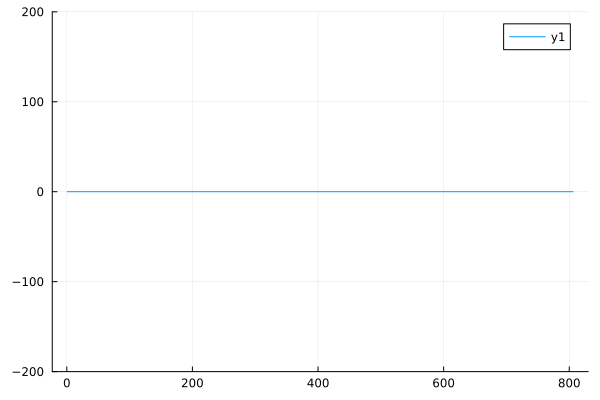

In [18]:
plot(z_trajectories, ylim=(-200,200))

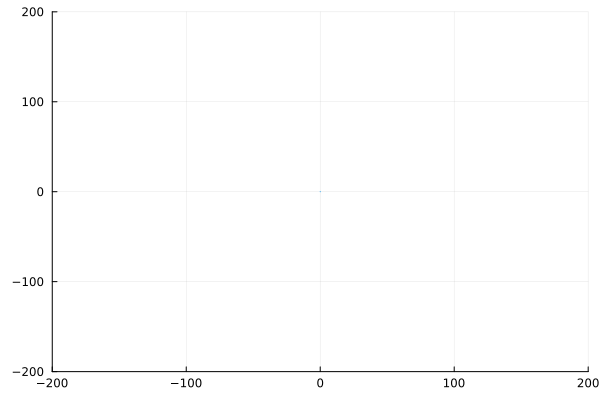

In [19]:
lim = 200
plot(x_trajectories, z_trajectories, legend=nothing, xlim=(-lim, lim), ylim=(-lim, lim))

In [2289]:
prob.p.n_scatters / t_end

31200.0

In [2290]:
function temperature(v)
    2m * mean(v.^2) / kB
end
;

In [2291]:
1e6 * temperature(x_velocities) |> display
1e6 * temperature(y_velocities) |> display
1e6 * temperature(z_velocities) |> display

22.266928236445047

19.853885274111907

26.238303792473793

In [1829]:
# TODOs
# Try Lambda loading but where the Lambda condition is satisfied at the bottom of the trap

### Run simulation for multiple particles in parallel

In [1845]:
@everywhere function prob_func(prob, i, repeat)
    
     lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.voltage,
        sim_params.aom_freq
    )
    
    # Define initial conditions for the molecule
    cloud_size = @with_unit 0.020 "mm"
    # cloud_size = @with_unit 0.0 "mm"
    particle = Particle()
    particle.r = (rand(Normal(0, cloud_size)), rand(Normal(0, cloud_size)), rand(Normal(0, cloud_size))) ./ (1/k)
    particle.v = sample_velocity(20e-6) ./ (Γ/k)
    
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    
    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    
    callback = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))
    
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p, callback=callback, reltol=5e-4, saveat=4000, maxiters=1000000000)
    
    return prob
end
;

In [1846]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
;

In [1847]:
n_molecules = 20
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=n_molecules)
;

552.977088 seconds (625.37 k allocations: 26.959 MiB)


In [1854]:
x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
y_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
times = Array{Vector{Float64}}(fill([],n_molecules))

for i ∈ 1:n_molecules
    sol_u = ensemble_sol[i].u
    sol_t = ensemble_sol[i].t
    
    x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u]./k*1e3 ]
    y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u]./k*1e3 ]
    z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u]./k*1e3 ]
    
    times[i] = sol_t .* (1/Γ)
end

trajectories = [
    [[x[1],x[2],x[3]] for x ∈ zip(x_trajectories[i],y_trajectories[i],z_trajectories[i])] 
    for i ∈ 1:n_molecules
    ]
;

In [1855]:
function survived(times)
    max_idx = maximum(length(time) for time ∈ times)
    _survived = zeros(Bool, length(times))
    for i ∈ eachindex(times)
        _survived[i] = length(times[i]) == max_idx
    end
    return _survived
end
survived_idxs = survived(times)
;

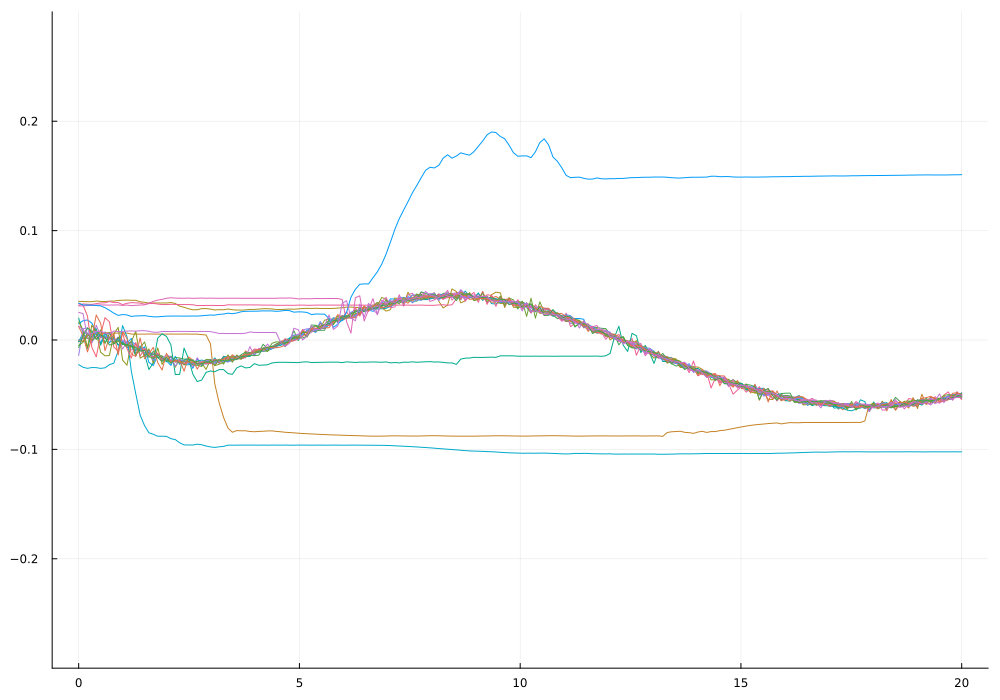

In [1856]:
lim = 0.3
plot()
for i ∈ 1:n_molecules
    plot!(times[i] .* 1e3, x_trajectories[i], legend=nothing, ylim=(-lim, lim))
end
plot!()
plot!(size=(1000,700))

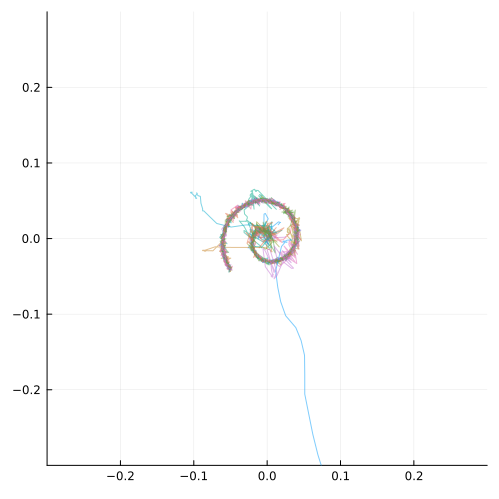

In [1857]:
lim = 0.3
plot(x_trajectories, z_trajectories, legend=nothing, xlim=(-lim, lim), ylim=(-lim, lim), alpha=0.5, size=(500,500))

In [1858]:
using Serialization
# serialize("300e-6 radius spiral.jl", ensemble_sol)

In [1877]:
mean(ensemble_sol[i].prob.p.n_scatters ./ times[i][end] for i ∈ (1:n_molecules)) |> display
mean(ensemble_sol[i].prob.p.n_scatters ./ times[i][end] for i ∈ (1:n_molecules)[_captured]) |> display

28752.5

33196.875

In [1868]:
prob.p.sim_params.ODT_position

2-element Vector{Float64}:
 3.203948315007329e-5
 3.1525207512565956e-5

In [1869]:
_captured = captured_in_ODT(trajectories[survived_idxs], times, 20e-3, prob)
;

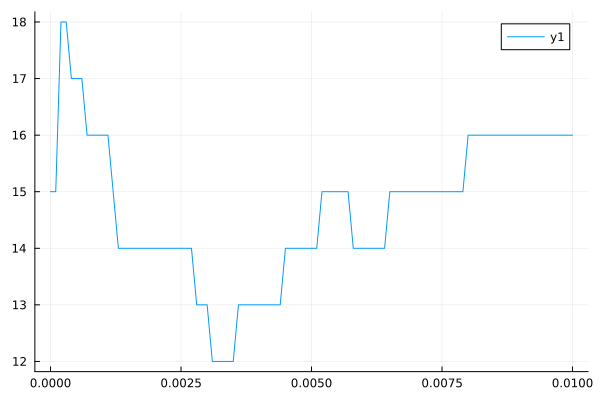

In [1876]:
ts = 0:0.1e-3:10e-3
captured = []

for t ∈ ts
    _captured = captured_in_ODT(trajectories[survived_idxs], times, t, prob)
    push!(captured, sum(_captured))
end
plot(ts, captured)

In [1871]:
function captured_in_ODT(trajectories, times, t, prob)
    n = 0
    
    update_ODT_center_spiral!(prob.p.sim_params, prob.p.extra_data, t / (1/Γ))
    ODT_position = prob.p.sim_params.ODT_position
    ODT_size = prob.p.sim_params.ODT_size
    
    captured = zeros(Bool, length(trajectories))
    
    for (i,trajectory) ∈ enumerate(trajectories)
        traj_idx = searchsortedfirst(times[i], t)
        if (abs(trajectory[traj_idx][1] - ODT_position[1] * 1e3) <= ODT_size[1] * 1e3) && 
            (abs(trajectory[traj_idx][2]) <= ODT_size[2] * 1e3) &&
            (abs(trajectory[traj_idx][3] - ODT_position[2] * 1e3) <= ODT_size[3] * 1e3)
            captured[i] = true
        end
    end
    return captured
end
;